<center><h1>Chang_Yi_HW5</h1></center>
<br>
<br>

Name: Yi Chang 
<br>
Github Username: Evangeline-Chang
<br>
USC ID: 1959039727

## 1. Decision Trees as Interpretable Models

Import packages

In [113]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import math
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
import xgboost as xgb

### (a) Obtain Data

Get the Accute Inamations Data Set

In [114]:
data = pd.read_csv('../data/diagnosis.data', sep='\s+', encoding='UTF_16', header=None, decimal=',',
                   names=['temperature', 'nausea', 'lumbar', 'urine', 'micturition', 'burning', 'decision_inflame', 'decision_nephritis'])

names = ['nausea', 'lumbar', 'urine', 'micturition', 'burning', 'decision_inflame', 'decision_nephritis']
for i in names:
    data[i] = data[i].replace({'yes': 1, 'no': 0})

### (b) Build a decision tree

|--- temperature <= 37.95
|   |--- urine <= 0.50
|   |   |--- class: 0
|   |--- urine >  0.50
|   |   |--- class: 1
|--- temperature >  37.95
|   |--- lumbar <= 0.50
|   |   |--- class: 0
|   |--- lumbar >  0.50
|   |   |--- micturition <= 0.50
|   |   |   |--- class: 0
|   |   |--- micturition >  0.50
|   |   |   |--- urine <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- urine >  0.50
|   |   |   |   |--- class: 0



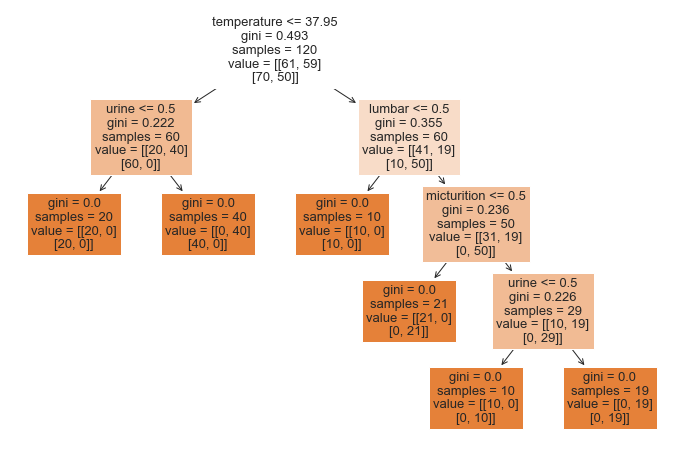

In [115]:
X = data.drop(columns=['decision_inflame', 'decision_nephritis'], axis=1)
y = data[['decision_inflame', 'decision_nephritis']]

clf = DecisionTreeClassifier()

clf.fit(X, y)

tree_text = export_text(clf, feature_names=X.columns.tolist())
print(tree_text)

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns.tolist(), filled=True)
plt.show()

### (c) Convert the decision rules

In [116]:
def tree_to_pseudo(tree, feature_names):
	left = tree.tree_.children_left
	right = tree.tree_.children_right
	threshold = tree.tree_.threshold
	features = [feature_names[i] for i in tree.tree_.feature]
	value = tree.tree_.value

	def recurse(left, right, threshold, features, node, depth=0):
		indent = "  " * depth
		if (threshold[node] != -2):
			print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
			if left[node] != -1:
				recurse (left, right, threshold, features, left[node], depth+1)
				print(indent,"} else {")
				if right[node] != -1:
					recurse (left, right, threshold, features, right[node], depth+1)
				print(indent,"}")
		else:
			print(indent,"return " + str(value[node]))

	recurse(left, right, threshold, features, 0)

In [117]:
tree_to_pseudo(clf, X.columns.tolist())

 if ( temperature <= 37.95000076293945 ) {
   if ( urine <= 0.5 ) {
     return [[20.  0.]
 [20.  0.]]
   } else {
     return [[ 0. 40.]
 [40.  0.]]
   }
 } else {
   if ( lumbar <= 0.5 ) {
     return [[10.  0.]
 [10.  0.]]
   } else {
     if ( micturition <= 0.5 ) {
       return [[21.  0.]
 [ 0. 21.]]
     } else {
       if ( urine <= 0.5 ) {
         return [[10.  0.]
 [ 0. 10.]]
       } else {
         return [[ 0. 19.]
 [ 0. 19.]]
       }
     }
   }
 }


### (d) Cost-complexity pruning to a minimal decision tree

In [118]:
path = clf.cost_complexity_pruning_path(X, y)
alphas = path['ccp_alphas']

X = data.drop(columns=['decision_inflame', 'decision_nephritis'], axis=1)
y = data[['decision_inflame', 'decision_nephritis']]

accuracy = []

for path in alphas:
    clf = DecisionTreeClassifier(ccp_alpha = path)
    clf.fit(X, y)
    y_pred = clf.predict(X)

    acc = accuracy_score(y, y_pred)
    accuracy.append(acc)

for alpha, acc in zip(alphas, accuracy):
    print(f'Alpha: {alpha:.4f}, Accuracy: {acc:.4f}')

best_alpha = alphas[accuracy.index(max(accuracy))]
print(f'\nBest Alpha: {best_alpha:.4f}')

Alpha: 0.0000, Accuracy: 1.0000
Alpha: 0.0491, Accuracy: 0.8417
Alpha: 0.0795, Accuracy: 0.7583
Alpha: 0.1111, Accuracy: 0.5917
Alpha: 0.2042, Accuracy: 0.2500

Best Alpha: 0.0000


The tree after cost-complexity pruning is the same as the original tree, and it's probably because the original tree is not very complex or deep.

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [119]:
communities = pd.read_csv('../data/communities.csv', header=None)
column_names = pd.read_csv('../data/attributes.csv')
column_names = column_names.T
column_names = column_names.applymap(lambda x: x.strip().replace(" ", ""))
communities.columns = column_names.iloc[0]

# set training and test
training = communities.head(1495)
test = communities.tail(len(communities) - 1495)

### (b) Missing values

In [120]:
# Ignore nonpredictive feature
training = training.drop(columns=['state', 'county', 'community', 'communityname', 'fold'], axis=1)
test = test.drop(columns=['state', 'county', 'community', 'communityname', 'fold'], axis=1)

# replace missing values with median
# I used median instead of mean because the test error for linear regression model will be very huge if I used mean.
training.replace('?', np.nan, inplace=True)
training = training.apply(pd.to_numeric, errors='ignore')
median_values = training.median()
training.fillna(median_values, inplace=True)

test.replace('?', np.nan, inplace=True)
test = test.apply(pd.to_numeric, errors='ignore')
median_values = test.median()
test.fillna(median_values, inplace=True)

### (c) Plot a correlation matrix

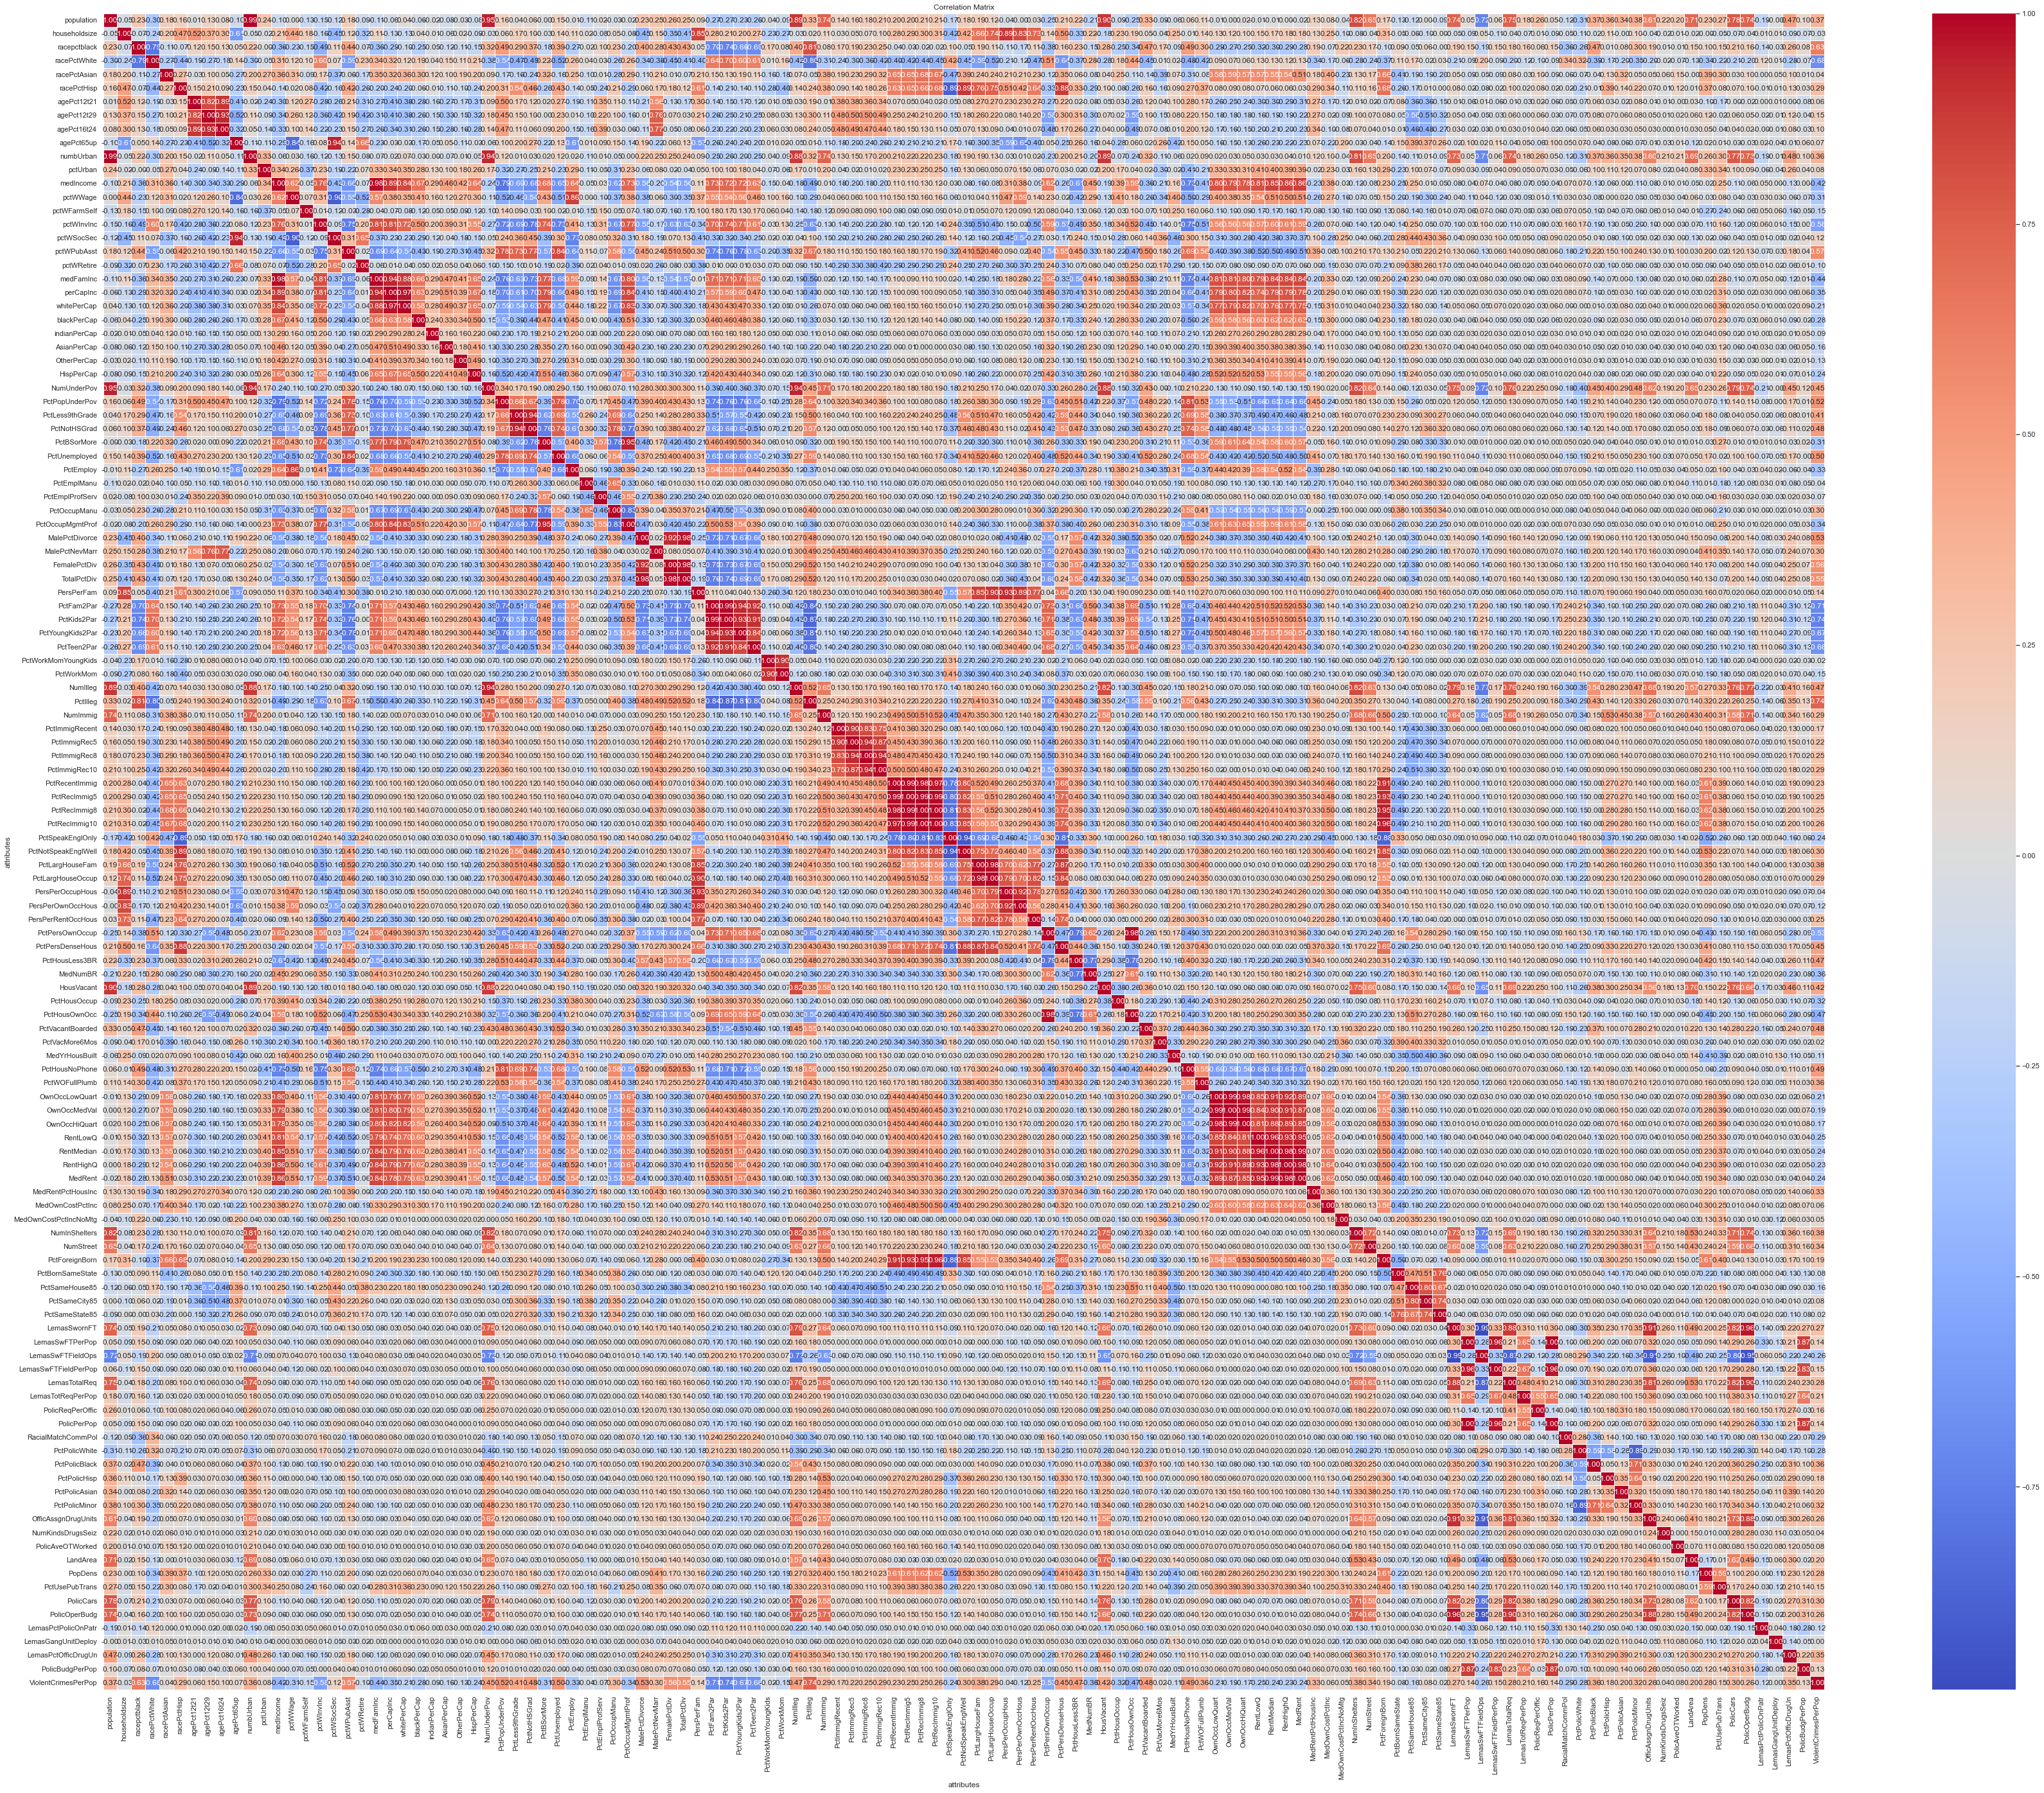

In [121]:
communities_new = pd.concat([training, test])
correlation_matrix = communities_new.corr()

plt.figure(figsize=(60, 48))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix")
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [122]:
means = communities_new.mean()
std = communities_new.std()
cv = std / means

cv_df = pd.DataFrame({'Feature': cv.index, 'CV': cv.values})
cv_df

Feature        CV
0             population  2.203503
1          householdsize  0.353298
2           racepctblack  1.410920
3           racePctWhite  0.323782
4           racePctAsian  1.359162
..                   ...       ...
118  LemasPctPolicOnPatr  0.119000
119  LemasGangUnitDeploy  0.333483
120  LemasPctOfficDrugUn  2.555266
121      PolicBudgPerPop  0.422669
122  ViolentCrimesPerPop  0.979015

[123 rows x 2 columns]

### (e) Scatter plots and box plots for highest CV features

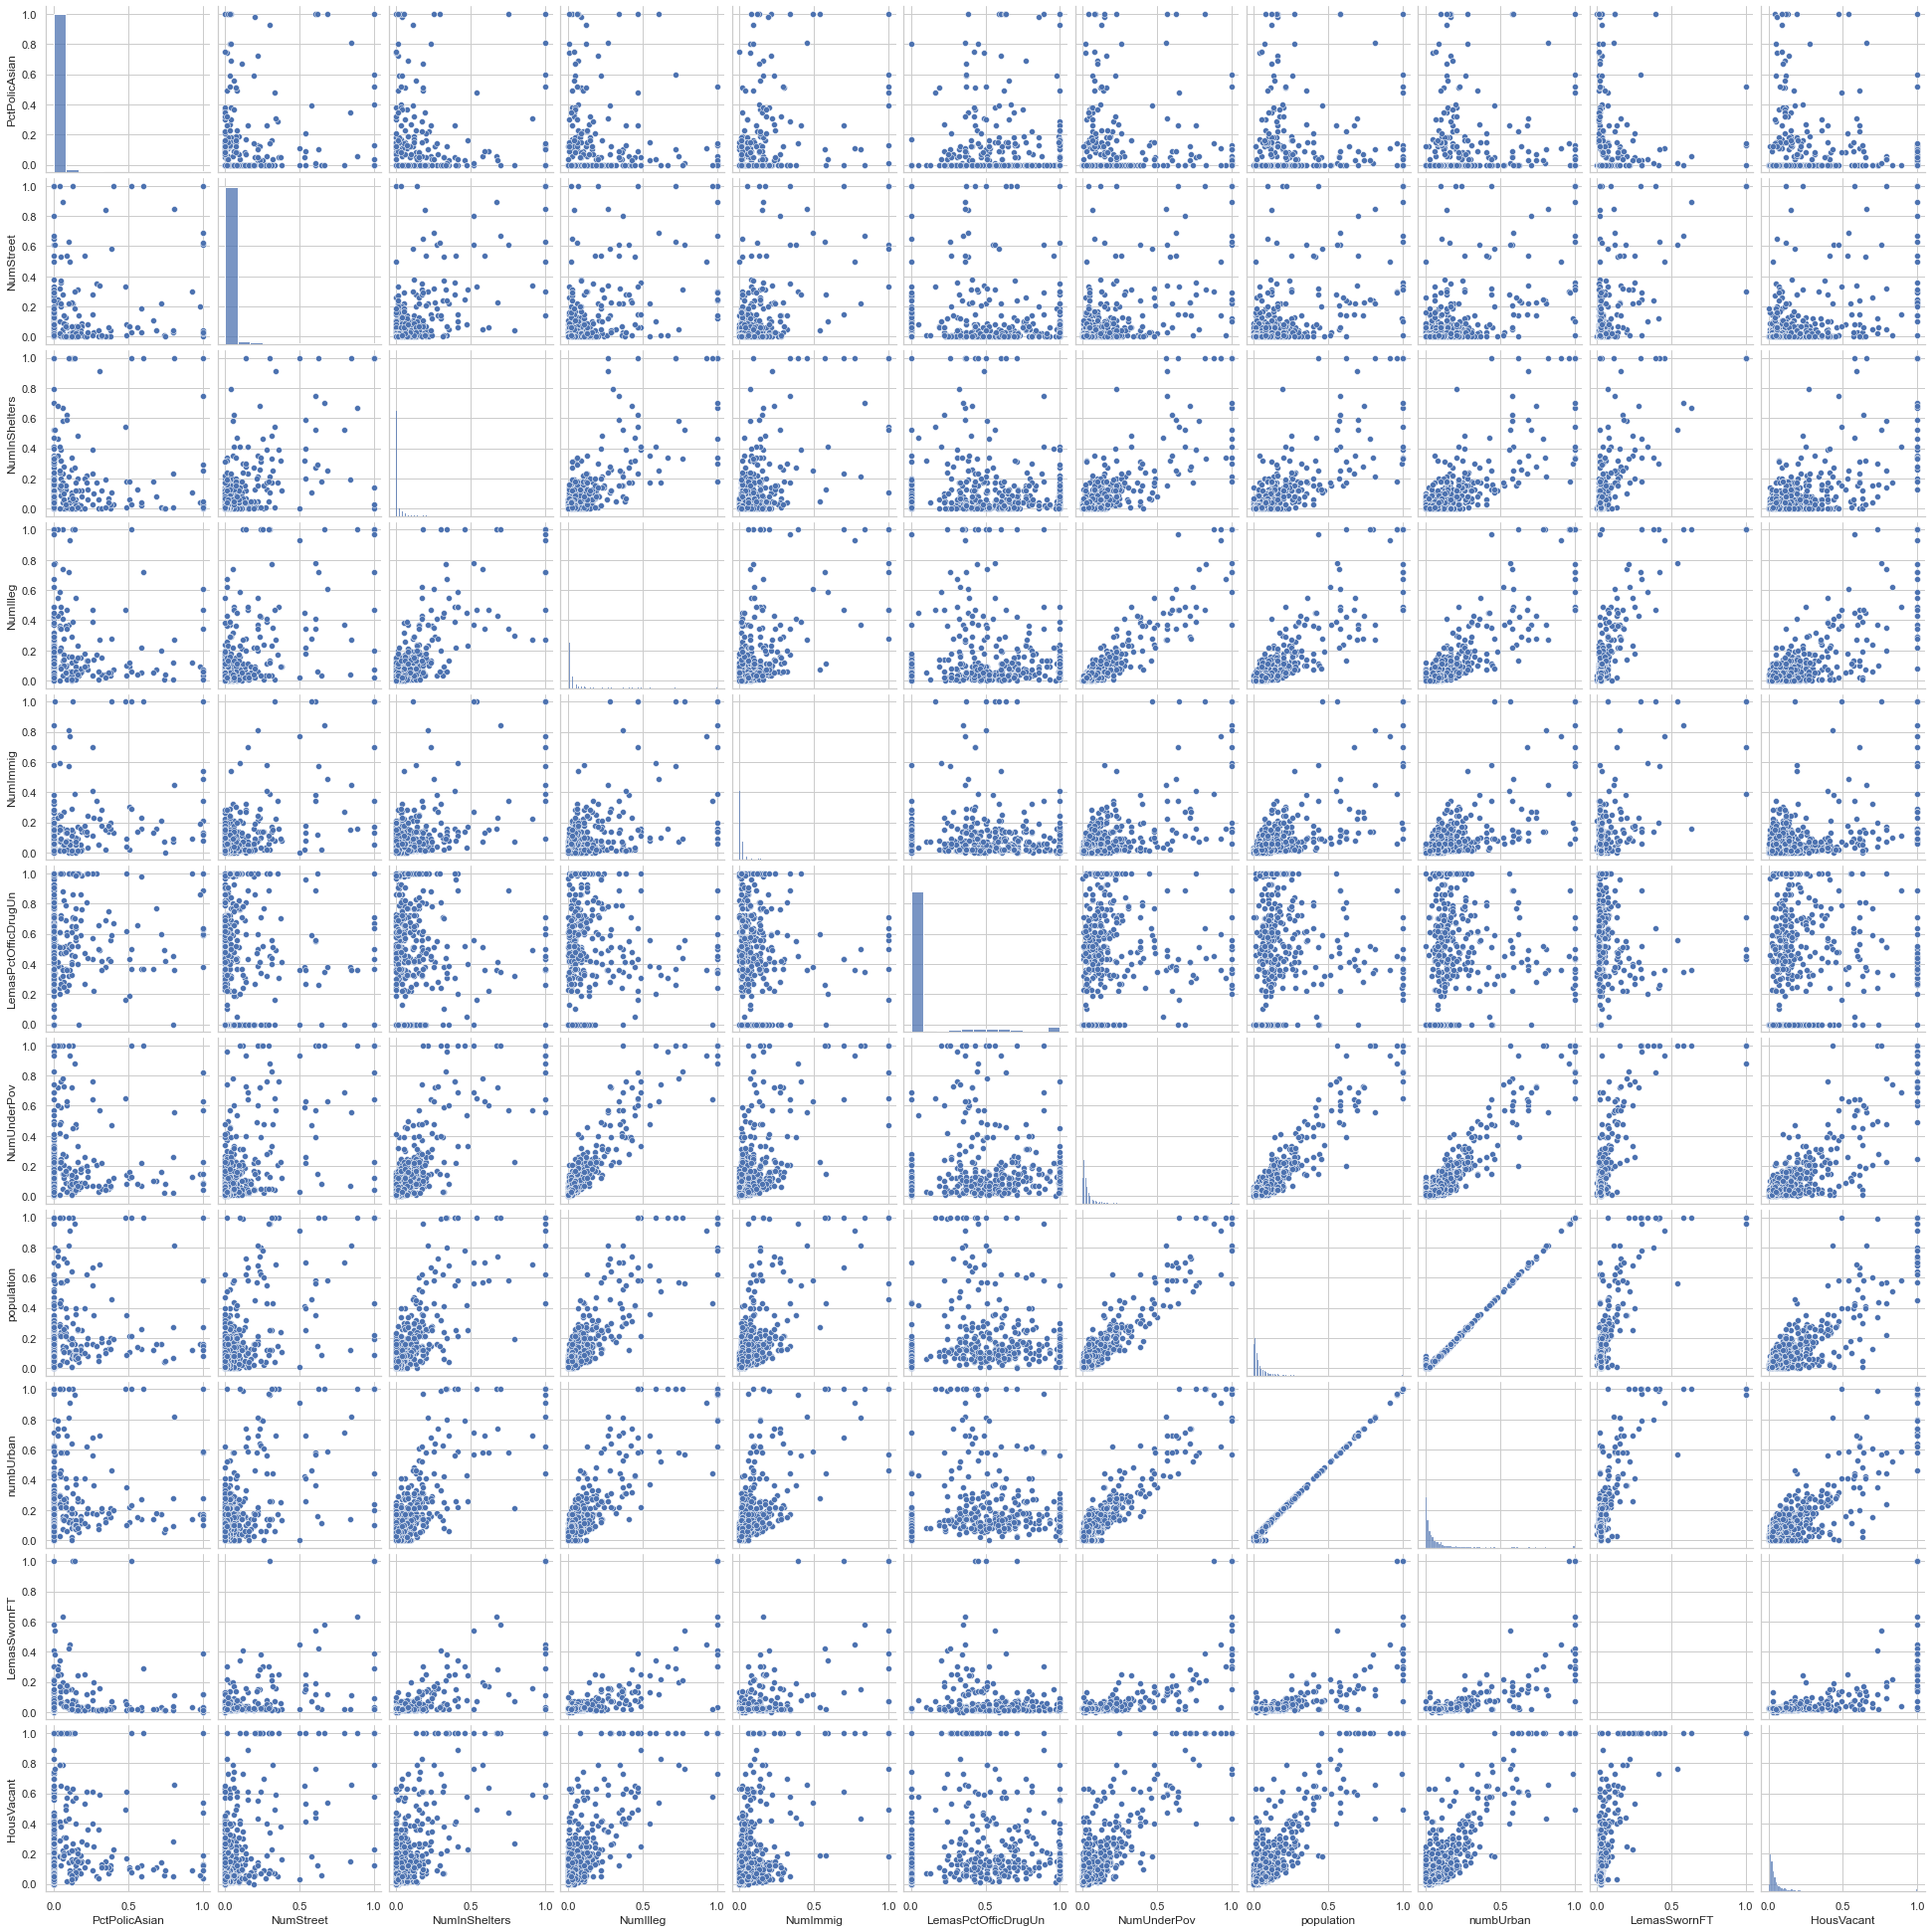

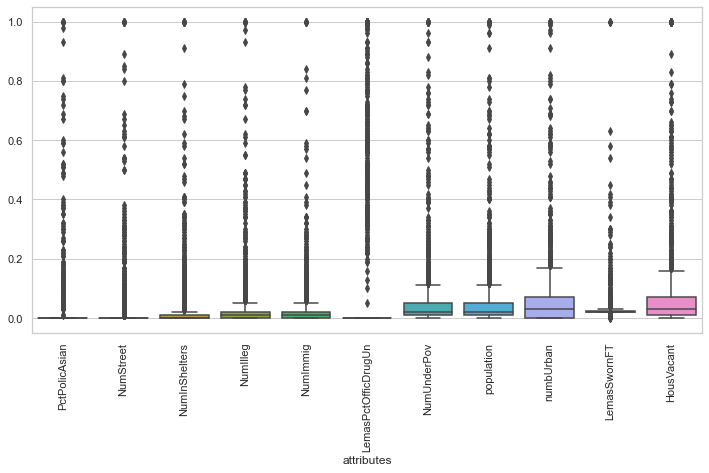

In [123]:
top_features = cv_df.sort_values(by='CV', ascending=False).head(int(math.sqrt(128)))

selected_features = communities_new[top_features['Feature']]

sns.set(style="whitegrid")
sns.pairplot(selected_features, height=2.5)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=selected_features, orient='v')
plt.xticks(rotation=90)
plt.show()

It seems that there are correlations between some of the features, but might need models to test them.

### (f) Fit a linear model

In [124]:
X_train = training.drop(columns=['ViolentCrimesPerPop'])
X_test = test.drop(columns=['ViolentCrimesPerPop'])
y_train = training[['ViolentCrimesPerPop']]
y_test = test[['ViolentCrimesPerPop']]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_error = mean_squared_error(y_test, y_pred)

print(f"Test Error: {test_error:.3f}")

Test Error: 0.018


### (g) Fit a ridge regression model

In [125]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']

ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

test_error = mean_squared_error(y_test, y_pred)

print(f"Best Lambda: {best_alpha:.3f}")
print(f"Test Error: {test_error:.3f}")

Best Lambda: 1.000
Test Error: 0.018


### (h) Fit a LASSO model

In [126]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 50, 100, 500]} 
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']

lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)

test_error = mean_squared_error(y_test, y_pred)

selected_variables = [feature for feature, coef in zip(communities_new.columns, lasso_model.coef_) if coef != 0]

print(f"Best Lambda: {best_alpha:.2f}")
print(f"Test Error: {test_error:.3f}")
print(f"Selected Variables: {', '.join(selected_variables)}")

Best Lambda: 0.01
Test Error: 0.021
Selected Variables: racePctWhite, PctKids2Par, PctIlleg


#### Standardized

In [127]:
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

param_grid = {'alpha': [0.01, 0.1, 1, 10, 50, 100, 500]}
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_standardized, y_train)

best_alpha = grid_search.best_params_['alpha']

lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train_standardized, y_train)

y_pred = lasso_model.predict(X_test_standardized)

test_error_standardized = mean_squared_error(y_test, y_pred)

selected_variables = [feature for feature, coef in zip(communities_new.columns, lasso_model.coef_) if coef != 0]

print(f"Best Lambda: {best_alpha:.2f}")
print(f"Test Error (Standardized): {test_error_standardized:.3f}")
print(f"Selected Variables: {', '.join(selected_variables)}")

Best Lambda: 0.01
Test Error (Standardized): 0.017
Selected Variables: racepctblack, racePctWhite, pctUrban, MalePctDivorce, PctKids2Par, PctWorkMom, PctIlleg, PctPersDenseHous, HousVacant, PctHousOccup, PctVacantBoarded, MedRentPctHousInc, NumStreet, PctForeignBorn, LemasTotReqPerPop, PolicReqPerOffic


After standarization, the test error improved from 0.021 to 0.017, and there are 13 more selected variables, which may contribute to the model's improved performance. Additionally, the best lambda choice is the same after standarization, indicating that the regularization strength was effective in controlling the complexity of the models

### (i) Fit a PCR model

In [128]:
lasso_mse = []
for comp in range(1, 123):
    pca = PCA(n_components=comp)
    X_PCA = pca.fit_transform(scale(X_train))
    kf = KFold(n_splits=5)
    MSE = []
    for train_ind,val_ind in kf.split(X_PCA):
        x_train1, x_val1 = X_PCA[train_ind.tolist()], X_PCA[val_ind.tolist()]
        y_train1, y_val1 = np.array(y_train)[train_ind.tolist()], np.array(y_train)[val_ind.tolist()]
        model = LinearRegression()
        model = model.fit(x_train1, y_train1)
        pred = model.predict(x_val1)
        actual = y_val1
        mse = mean_squared_error(actual, pred)
        MSE.append(mse)
    lasso_mse.append(np.mean(MSE))

mse_min = pd.DataFrame({"Number of Components (M)": range(1, 123),"Validation MSE":lasso_mse})
mse_min = mse_min.sort_values(by='Validation MSE').head(1)
M = mse_min.iloc[0, 0]
print(f'Number of Components (M): {M}')

pca = PCA(n_components = M)
X_PCA_train = pca.fit_transform(scale(X_train))
X_PCA_test = pca.fit_transform(scale(X_test))
model = linear_model.LinearRegression()
model = model.fit(X_PCA_train,y_train)
pred = model.predict(X_PCA_test)
actual = y_test
mse = mean_squared_error(actual, pred)
print(f"Test Error for M = {M} components: {mse:.3f}")

Number of Components (M): 95
Test Error for M = 95 components: 0.031


### (j) Fit a boosting tree

In [129]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4, 5, 10, 20]} 
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['learning_rate']

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=best_alpha)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

test_error = mean_squared_error(y_test, y_pred)

print(f"Best Learning Rate (α): {best_alpha:.2f}")
print(f"Test Error: {test_error:.3f}")

Best Learning Rate (α): 0.05
Test Error: 0.017
